# Heisenberg XXZ model (v.1)

#  1. Imports

In [1]:

# qiskit imports
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.providers.aer.noise as noise
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")
import basic_circuits as circuits
from networks import IsoMPS
from isonetwork import QKParamCircuit, IsoTensor
import matplotlib.pyplot as plt

# tenpy imports
import tenpy as tp
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.spins import SpinModel
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite

# classical circuit and thermal states imports
# import thermal state
#from thermal_state import thermal_state 
from circuit_qubit1 import Circuit
from hamiltonian import model_mpo


# 2. Circuit structure (qiskit-based)

In [343]:

# model params 
J = 1 # spin-exchange
Delta = 1 # Ising-anisotropy
hz = 0 # z-field
L = 2 # repetition of unit-cell
l_uc = 2 # number of sites in unit cell
N = L * l_uc # number of sites
nb = 1 # should change this for each nb
d = 2
chi = 2*nb

In [344]:

# qiskit circuit structure
def circuit(nb,params):
    backend = qk.Aer.get_backend('unitary_simulator')
    c = qk.QuantumCircuit(nb+1)
    if nb == 1:
        circuits.add_su4_circ(c, 1, 0, params[:15])
    if nb ==2:
        circuits.add_su4_circ(c, 2, 0, params[:15])
        circuits.add_su4_circ(c, 2, 1, params[15:30])
        circuits.add_su4_circ(c, 1, 0, params[30:])
    job = qk.execute(c, backend)
    result = job.result()
    #get the unitary matrix from the result object
    return result.get_unitary(c, decimals=8)

backend = qk.Aer.get_backend('qasm_simulator')
c = qk.QuantumCircuit(nb+1,2)
circuits.add_su4_circ(c, 1, 0, sweet_spot[2:]) 
c.draw('mpl')
c.measure(0,0)
job = qk.execute(c, backend,shots = 400)
result = job.result()
result.get_counts()

{'00': 167, '01': 233}

# 3. Free energy simulations

In [345]:

# DMRG code for computing GS energy

__all__ = ['XXZModel', 'XXChain']
class XXZModel(CouplingMPOModel):
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            if self.verbose >= 1.:
                print(self.name + ": set conserve to", conserve)
        site = SpinHalfSite(conserve=conserve)
        return site
    def init_terms(self, model_params):
        J = np.asarray(model_params.get('J', 1.))
        d = np.asarray(model_params.get('d', 1.))
        h = np.asarray(model_params.get('h', 1.))
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(h, u, 'Sigmaz')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(J, u1, 'Sigmax', u2, 'Sigmax', dx)
            self.add_coupling(J, u1, 'Sigmay', u2, 'Sigmay', dx)
            self.add_coupling(J*d, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        # done
        
class XXZChain(XXZModel, NearestNeighborModel):
    def __init__(self, model_params):
        model_params = asConfig(model_params, self.__class__.__name__)
        model_params.setdefault('lattice', "Chain")
        CouplingMPOModel.__init__(self, model_params)
        
        
def DMRG_xxz(J,Delta,hz,chi_max,bc,L,verbose=False):
    model_params = dict(L=L, J=J, d=Delta, h = hz, bc_MPS=bc, 
                        conserve=None, verbose=verbose)
    M = XXZChain(model_params)
    product_state = ["down"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-6
        },
        'max_E_err': 1.e-6,
        'verbose': verbose,
    }
    eng = tp.algorithms.dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    print("E_dmrg = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.mean(psi.expectation_value("Sigmax"))
    mag_z = np.mean(psi.expectation_value("Sigmaz"))
    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
    #print("correlation length:", psi.correlation_length())
    if bc == 'infinite':
        E1 = E
    else:
        E1 = E/L
    return E1

In [346]:

# thermal-state-based Hamiltonian and boundary vects
Hamiltonian = model_mpo.xxz(J,Delta,hz,N)
chi_H = Hamiltonian[0,:,0,0].size # size of Hamiltonian bond leg dimension
H_bvecr = None
H_bvecl = np.zeros(chi_H)
H_bvecl[-1] = 1
bdry_vecs2 = [H_bvecl,H_bvecr]


In [347]:

# nb = 1
# free energy
T = 0
k = (2*nb-1)

def circuit_qubit_free_energy(x,*args):
    #circuit = args[0]
    L = args[1]
    T = args[2]
    Hamiltonian = args[3]
    chi_H = args[4]
    bdry_vecs1 = args[5]
    bdry_vecs2 = args[6]
    l_uc = args[7]
    unitary_list = [circuit(nb,x[2*l_uc:2*l_uc+15*k]).reshape((2, 2**nb, 2, 2**nb)),
                    circuit(nb,x[2*l_uc + 15*k:]).reshape((2, 2**nb, 2, 2**nb))]
    F = thermal_state.free_energy(unitary_list,
                                  x,'density_matrix',
                                  L,Hamiltonian,
                                  T, chi_H,
                                  bdry_vecs1,bdry_vecs2,
                                  'method_I',None,None) 
    return F

bdry_vecs1 = None
#### bdry_vecs1 = TBD for MPDO, bdry_vecs1 = [None,None] and for iMPDO, bdry_vecs1 = None
Hamiltonian = model_mpo.xxz(J,Delta,hz,N-1)
args = (c,L,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
rng = np.random.default_rng()
x0 = rng.uniform(high=2*np.pi,size = 2*15*k + 4)

result = minimize(circuit_qubit_free_energy,x0=x0,args=args,method = 'nelder-mead')
sweet_spot = result.x
free_energy = result.fun
print(f'Free energy = {free_energy}, T = {T}, nb = {nb}')
E_infinite = DMRG_xxz(J,Delta,hz,chi_max = 2*nb,bc='infinite',L=2,verbose=False)

Free energy = -1.7115863044368327, T = 0, nb = 1
E_dmrg = -1.7084204488003
final bond dimensions:  [2, 2]
<sigma_x> = -0.00000
<sigma_z> = 0.00000


/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [321]:

# nb = 2
# free energy
T = 0
k = (2*nb-1)

def circuit_qubit_free_energy(x,*args):
    #circuit = args[0]
    L = args[1]
    T = args[2]
    Hamiltonian = args[3]
    chi_H = args[4]
    bdry_vecs1 = args[5]
    bdry_vecs2 = args[6]
    l_uc = args[7]
    unitary_list = [circuit(nb,x[2*l_uc:2*l_uc+15*k]).reshape((2, 2**nb, 2, 2**nb)),
                    circuit(nb,x[2*l_uc + 15*k:]).reshape((2, 2**nb, 2, 2**nb))]
    F = thermal_state.free_energy(unitary_list,
                                  x,'density_matrix',
                                  L,Hamiltonian,
                                  T, chi_H,
                                  bdry_vecs1,bdry_vecs2,
                                  'method_I',None,None) 
    return F

bdry_vecs1 = None
#### bdry_vecs1 = TBD for MPDO, bdry_vecs1 = [None,None] and for iMPDO, bdry_vecs1 = None
Hamiltonian = model_mpo.xxz(J,Delta,hz,N-1)
args = (c,L,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
rng = np.random.default_rng()
x0 = rng.uniform(high=2*np.pi,size = 2*15*k + 4)

result = minimize(circuit_qubit_free_energy,x0=x0,args=args,method = 'nelder-mead')
sweet_spot = result.x
free_energy = result.fun
print(f'Free energy = {free_energy}, T = {T}, nb = {nb}')
E_infinite = DMRG_xxz(J,Delta,hz,chi_max = 2*nb,bc='infinite',L=2,verbose=False)

Free energy = -1.7620366365792055, T = 0, nb = 2
E_dmrg = -1.7608891769355
final bond dimensions:  [4, 4]
<sigma_x> = 0.00000
<sigma_z> = -0.00000


/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Should rerun the following cells separately for each nb

In [298]:

# nb = 1
T_list = []
x_list = [x0]
F_list = []

for i in range(10):
    args = (c,L,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
    result = minimize(circuit_qubit_free_energy,x0=x_list[len(T_list)-1],
                      args=args,method = 'nelder-mead')
    x_list.append(result.x)
    F_list.append(result.fun)
    T_list.append(T)    
    T = T + 0.2

In [310]:

# nb = 2
T_list4 = []
x_list4 = [x0]
F_list4 = []

for i in range(10):
    args = (c,L,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
    result = minimize(circuit_qubit_free_energy,x0=x_list4[len(T_list4)-1],
                      args=args,method = 'nelder-mead')
    x_list4.append(result.x)
    F_list4.append(result.fun)
    T_list4.append(T)    
    T = T + 0.2

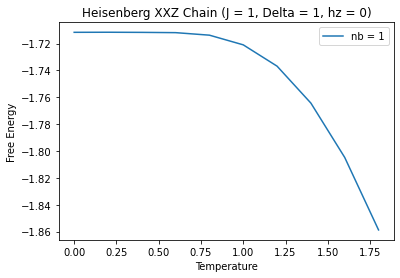

In [315]:

# example for nb = 1
plt.plot(T_list,F_list)
#plt.plot(T_list4,F_list4)
plt.legend(['nb = 1','nb = 2'])
plt.xlabel('Temperature')
plt.ylabel('Free Energy')
plt.title(f'Heisenberg XXZ Chain (J = {J}, Delta = {Delta}, hz = {hz})')
plt.show()

2. results of two runs for nb = 1 and 2

In [304]:

# results of one run for nb = 1
# for nb = 1
print(T_list)
print(x_list)
print(F_list)

[0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2, 1.4, 1.5999999999999999, 1.7999999999999998]
[array([0.03527594, 4.05425282, 3.39971463, 1.033524  , 5.22656395,
       3.60539244, 0.5373303 , 3.17469607, 2.3022618 , 1.57242222,
       2.91886345, 1.07754854, 6.14145416, 3.58949578, 5.31249014,
       3.1152972 , 6.25606456, 0.01718427, 4.88058889, 2.70019572,
       0.50298797, 5.44862745, 2.70531262, 2.10381281, 3.99833975,
       2.89016625, 4.04958186, 2.25680534, 4.49451739, 1.7220105 ,
       4.00301838, 5.9364337 , 6.26223707, 0.48149041]), array([0.0246511 , 3.72366533, 5.51865369, 0.82328706, 3.99225221,
       3.63355542, 0.78993077, 2.2555311 , 2.77766972, 0.62742554,
       4.74265091, 1.22124316, 6.01933867, 3.2686858 , 4.69149486,
       2.50517776, 5.88764995, 0.01771985, 5.62841705, 2.79346189,
       0.56100252, 6.99402743, 4.41670309, 1.60356985, 3.42438382,
       1.92588315, 5.08736432, 1.74217519, 3.3501241 , 1.92161288,
       4.08938548, 6.29962551, 5.83768189, 0

In [ ]:

# for nb = 2
print(x_list4)
print(F_list4)
print(T_list4)